# Project 4

In [1]:
import pandas as pd
import numpy as np 
import os
import seaborn as sns
import glob
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras import models, layers, optimizers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.datasets import mnist
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications import VGG16, VGG19

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

import lime
from lime import lime_base
from lime import lime_image
from skimage.segmentation import mark_boundaries

from PIL import Image
import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(os.getcwd())

/Users/andrewperry/flatiron/class-material/phase4/project4/dsc-phase-4-project


In [3]:
print(os.listdir())

['time-series', 'LICENSE.md', '.DS_Store', 'images', 'chest_xray', 'Project_4.ipynb', 'README.md', '.gitignore', 'CONTRIBUTING.md', '.canvas', '.ipynb_checkpoints', '.git']


In [4]:
print(os.listdir('chest_xray'))

['test', 'chest_xray', '__MACOSX', 'train', 'val']


In [5]:
print(os.listdir('chest_xray/train'))

['PNEUMONIA', 'NORMAL']


In [6]:
print(os.listdir('chest_xray/test'))

['PNEUMONIA', 'NORMAL']


In [7]:
print(os.listdir('chest_xray/val'))

['PNEUMONIA', 'NORMAL']


In [8]:
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'
val_dir = 'chest_xray/val'

In [9]:
print('train', len(os.listdir(train_dir)))
print('test', len(os.listdir(test_dir)))
print('val', len(os.listdir(val_dir)))

train 2
test 2
val 2


In [10]:
train_normal = 'chest_xray/train/NORMAL'
train_pneumonia = 'chest_xray/train/PNEUMONIA'


test_normal = 'chest_xray/test/NORMAL'
test_pneumonia = 'chest_xray/test/PNEUMONIA'

val_normal = 'chest_xray/val/NORMAL'
val_pneumonia = 'chest_xray/val/PNEUMONIA'

print('Train normal', len(os.listdir(train_normal)))
print('Train pneumonia', len(os.listdir(train_pneumonia)))
print('Test normal', len(os.listdir(test_normal)))
print('Test pneumonia', len(os.listdir(test_pneumonia)))
print('Val normal', len(os.listdir(val_normal)))
print('Val pneumonia', len(os.listdir(val_pneumonia)))

Train normal 1341
Train pneumonia 3875
Test normal 234
Test pneumonia 390
Val normal 8
Val pneumonia 8


In [11]:
# create data generators and make sure class mode is binary
# make batch size based on train, test, and val

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
                                                      'chest_xray/train',
                                                      target_size = (128, 128),
                                                      batch_size = 5216,
                                                      class_mode = 'binary')

Found 5216 images belonging to 2 classes.


In [12]:
test_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
'chest_xray/test',
target_size = (128, 128), 
batch_size = 624,
class_mode = 'binary')

Found 624 images belonging to 2 classes.


In [13]:
val_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
'chest_xray/val', 
target_size = (128, 128),
batch_size = 16, 
class_mode = 'binary')

Found 16 images belonging to 2 classes.


In [14]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [15]:
print('train',train_generator.class_indices)
print('test',test_generator.class_indices)
print('val',val_generator.class_indices)

train {'NORMAL': 0, 'PNEUMONIA': 1}
test {'NORMAL': 0, 'PNEUMONIA': 1}
val {'NORMAL': 0, 'PNEUMONIA': 1}


In [16]:
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

(5216, 128, 128, 3)
(624, 128, 128, 3)
(16, 128, 128, 3)


In [17]:
print(train_labels[:20])
print(train_labels.shape)


[1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0.]
(5216,)


Normal xray
0.0


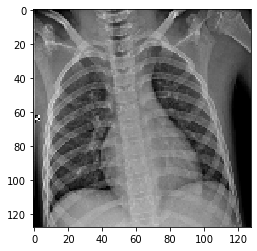

In [19]:
print('Normal xray')
plt.imshow(train_images[1])
print(train_labels[1])

Pneumonia xray
1.0


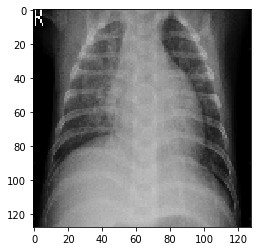

In [24]:
print('Pneumonia xray')
plt.imshow(train_images[2])
print(train_labels[2])

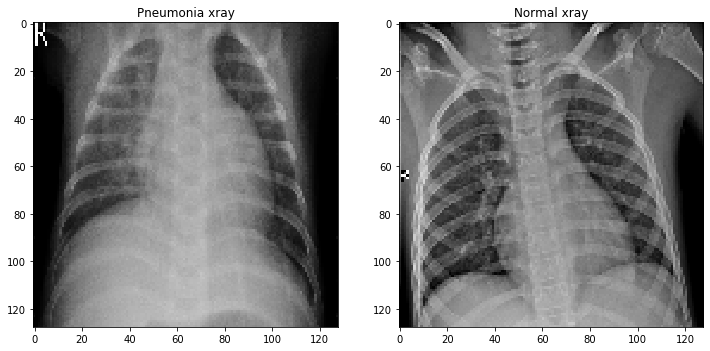

<Figure size 432x288 with 0 Axes>

In [195]:
fig, axes = plt.subplots(1, 2, figsize = (12,8))
axes[0].imshow(train_images[2])
axes[1].imshow(train_images[1])
axes[0].set_title('Pneumonia xray')
axes[1].set_title('Normal xray')
plt.show()
#plt.savefig('original_xray.png')

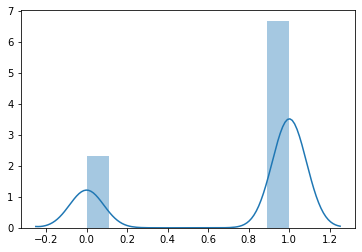

In [26]:
sns.distplot(train_labels)



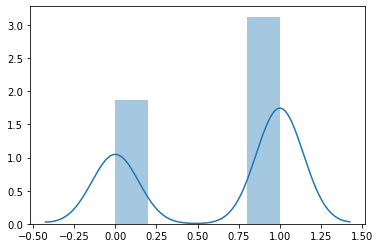

In [27]:
sns.distplot(test_labels)

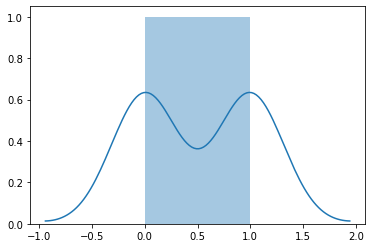

In [28]:
sns.distplot(val_labels)

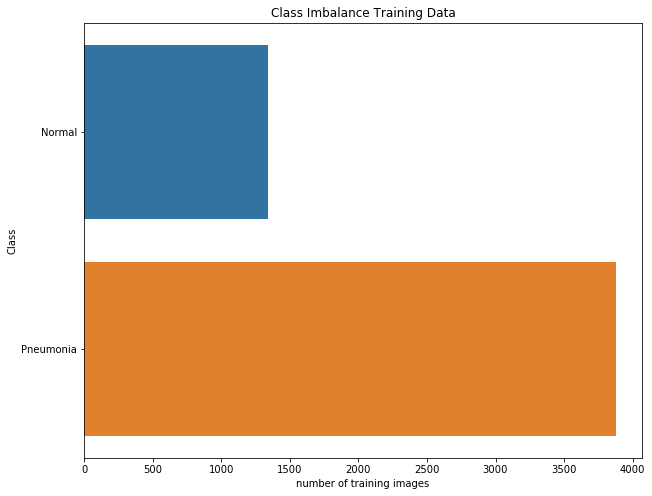

<Figure size 432x288 with 0 Axes>

In [202]:
plt.figure(figsize = (10, 8))
sns.barplot(x = [sum(train_labels == 0), sum(train_labels == 1)],
           y = ['Normal', 'Pneumonia'])
plt.title('Class Imbalance Training Data')
plt.ylabel('Class')
plt.xlabel('number of training images')
plt.show()
#plt.savefig('class_imbalance.png')


## Baseline model



In [30]:
# making a baseline model with 3 convolutional layers, 3 maxpooling layers and 1 fully connected layer

baseline = Sequential()

baseline.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 3)))
baseline.add(MaxPooling2D(2, 2))

baseline.add(Conv2D(32, (3, 3), activation = 'relu'))
baseline.add(MaxPooling2D(2, 2))

baseline.add(Conv2D(64, (3, 3), activation = 'relu'))
baseline.add(MaxPooling2D(2, 2))

baseline.add(Flatten())
baseline.add(Dense(32, activation = 'relu'))
baseline.add(Dense(1, activation = 'sigmoid'))


baseline.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['acc'])

In [31]:
baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [32]:
start = datetime.datetime.now()

results = baseline.fit(train_images, train_labels, epochs = 30, batch_size = 100,
                               validation_data = (val_images, val_labels))

Epoch 1/30
53/53 [==============================] - 44s 818ms/step - loss: 0.5985 - acc: 0.7456 - val_loss: 0.8309 - val_acc: 0.5000
Epoch 2/30
53/53 [==============================] - 43s 819ms/step - loss: 0.5566 - acc: 0.7443 - val_loss: 0.8625 - val_acc: 0.5000
Epoch 3/30
53/53 [==============================] - 43s 810ms/step - loss: 0.5093 - acc: 0.7525 - val_loss: 1.2757 - val_acc: 0.5000
Epoch 4/30
53/53 [==============================] - 42s 800ms/step - loss: 0.4749 - acc: 0.8001 - val_loss: 0.6962 - val_acc: 0.6250
Epoch 5/30
53/53 [==============================] - 43s 806ms/step - loss: 0.4325 - acc: 0.7938 - val_loss: 0.6680 - val_acc: 0.6250
Epoch 6/30
53/53 [==============================] - 43s 811ms/step - loss: 0.3787 - acc: 0.8450 - val_loss: 0.9766 - val_acc: 0.6250
Epoch 7/30
53/53 [==============================] - 43s 808ms/step - loss: 0.3357 - acc: 0.8569 - val_loss: 0.5767 - val_acc: 0.7500
Epoch 8/30
53/53 [==============================] - 43s 818ms/step - 

In [33]:
end = datetime.datetime.now()
elapsed = end - start
print('took {} to execute'.format(elapsed))

took 0:22:39.326812 to execute


### baseline model results

In [34]:
# Displaying the model results

def model_results(results, test_labels = test_labels):
    
    history = results.history
    plt.figure()
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.legend(['acc', 'val_acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    y_hat_test = results.model.predict(test_images)
    thresh = 0.5
    y_pred = (y_hat_test < thresh).astype(np.int)
    y_true = test_labels.astype(np.int)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, linecolor = 'black', linewidth = 1, annot = True, cmap = 'Blues', fmt = '')
    plt.xlabel('Predictions')
    plt.ylabel('True')
    plt.title('Model Confusion Matrix')
    plt.show()

    print(classification_report(y_true, y_pred))
    print('\n\n')
    
    test_loss, test_acc = results.model.evaluate(test_images, test_labels)
    print('Test loss:', test_loss)
    print('Test acc:', test_acc)


   

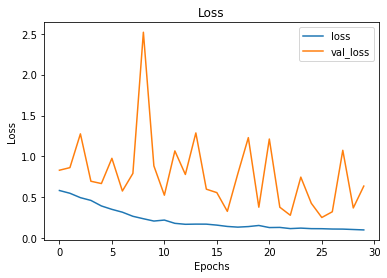

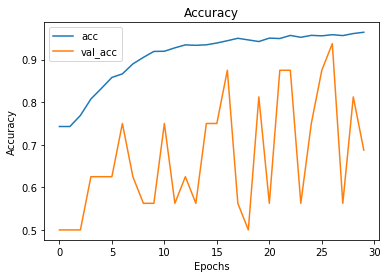

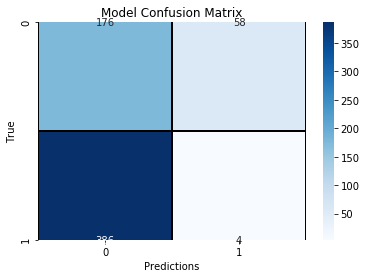

              precision    recall  f1-score   support

           0       0.31      0.75      0.44       234
           1       0.06      0.01      0.02       390

    accuracy                           0.29       624
   macro avg       0.19      0.38      0.23       624
weighted avg       0.16      0.29      0.18       624




20/20 [==============================] - 1s 72ms/step - loss: 1.0961 - acc: 0.7115
Test loss: 1.0961029529571533
Test acc: 0.7115384340286255


In [35]:
model_results(results)



## Model 2


In [38]:
# trying class weights and early stopping

In [37]:
# class weights
weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)
weight_dict = dict(zip(np.unique(train_labels), weights))
weight_dict

{0.0: 1.9448173005219984, 1.0: 0.6730322580645162}

In [38]:
# early stopping

early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10)
lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = .5, patience = 5)
callbacks = [early_stop, lr_reduce]

In [39]:
start = datetime.datetime.now()


model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 3)))
model2.add(MaxPooling2D(2, 2))

model2.add(Conv2D(32, (3, 3), activation = 'relu'))
model2.add(MaxPooling2D(2, 2))

model2.add(Conv2D(64, (3, 3), activation = 'relu'))
model2.add(MaxPooling2D(2, 2))

model2.add(Flatten())
model2.add(Dense(32, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))

model2.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['acc'])



In [40]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)            

In [41]:


results = model2.fit(train_images,
                           train_labels, 
                           epochs = 20,
                           batch_size = 80,
                           validation_data = (val_images, val_labels),
                           class_weight = weight_dict, 
                           callbacks = callbacks)

Epoch 1/20
66/66 [==============================] - 43s 642ms/step - loss: 0.6851 - acc: 0.4384 - val_loss: 0.6570 - val_acc: 0.6875
Epoch 2/20
66/66 [==============================] - 42s 631ms/step - loss: 0.6179 - acc: 0.7177 - val_loss: 0.5811 - val_acc: 0.6250
Epoch 3/20
66/66 [==============================] - 42s 636ms/step - loss: 0.5243 - acc: 0.7243 - val_loss: 0.7055 - val_acc: 0.6250
Epoch 4/20
66/66 [==============================] - 43s 643ms/step - loss: 0.4561 - acc: 0.7765 - val_loss: 0.5642 - val_acc: 0.7500
Epoch 5/20
66/66 [==============================] - 43s 646ms/step - loss: 0.3545 - acc: 0.8573 - val_loss: 0.5000 - val_acc: 0.7500
Epoch 6/20
66/66 [==============================] - 43s 655ms/step - loss: 0.2961 - acc: 0.8801 - val_loss: 0.7432 - val_acc: 0.6250
Epoch 7/20
66/66 [==============================] - 44s 667ms/step - loss: 0.2764 - acc: 0.8918 - val_loss: 0.4596 - val_acc: 0.7500
Epoch 8/20
66/66 [==============================] - 44s 668ms/step - 

### model 2 results

time 0:17:36.703142


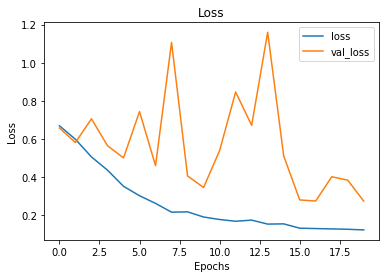

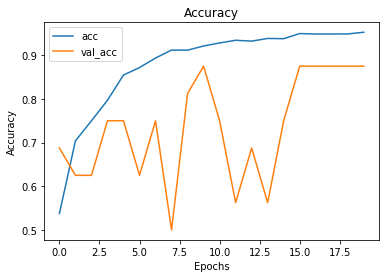

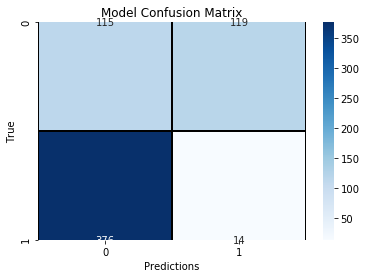

              precision    recall  f1-score   support

           0       0.23      0.49      0.32       234
           1       0.11      0.04      0.05       390

    accuracy                           0.21       624
   macro avg       0.17      0.26      0.19       624
weighted avg       0.15      0.21      0.15       624




20/20 [==============================] - 1s 68ms/step - loss: 0.5945 - acc: 0.7933
Test loss: 0.594455897808075
Test acc: 0.7932692170143127


In [42]:
end = datetime.datetime.now()
elapsed = end - start
print('time {}'.format(elapsed))

model_results(results)



## model 3

In [43]:
# try changing the validation set size

In [44]:
model3 = Sequential()

model3.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 3)))
model3.add(MaxPooling2D(2, 2))

model3.add(Conv2D(32, (3, 3), activation = 'relu'))
model3.add(MaxPooling2D(2, 2))

model3.add(Conv2D(64, (3, 3), activation = 'relu'))
model3.add(MaxPooling2D(2, 2))

model3.add(Flatten())
model3.add(Dense(32, activation = 'relu'))
model3.add(Dense(1, activation = 'sigmoid'))

model3.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['acc'])



In [45]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)            

In [47]:
start = datetime.datetime.now()

results = model3.fit(train_images, 
                           train_labels,
                           epochs = 40,
                           batch_size = 80,
                           validation_split = .2,
                           validation_data = (val_images, val_labels),
                           class_weight = weight_dict,
                           callbacks = callbacks)

Epoch 1/40
53/53 [==============================] - 39s 721ms/step - loss: 0.6857 - acc: 0.5141 - val_loss: 0.6925 - val_acc: 0.3956
Epoch 2/40
53/53 [==============================] - 38s 708ms/step - loss: 0.6761 - acc: 0.5007 - val_loss: 0.7072 - val_acc: 0.2854
Epoch 3/40
53/53 [==============================] - 38s 718ms/step - loss: 0.6525 - acc: 0.5664 - val_loss: 0.6775 - val_acc: 0.4684
Epoch 4/40
53/53 [==============================] - 38s 723ms/step - loss: 0.5874 - acc: 0.7322 - val_loss: 0.4191 - val_acc: 0.8046
Epoch 5/40
53/53 [==============================] - 40s 747ms/step - loss: 0.5450 - acc: 0.7242 - val_loss: 0.4029 - val_acc: 0.7692
Epoch 6/40
53/53 [==============================] - 39s 732ms/step - loss: 0.4638 - acc: 0.7888 - val_loss: 0.6162 - val_acc: 0.6523
Epoch 7/40
53/53 [==============================] - 39s 741ms/step - loss: 0.4433 - acc: 0.7869 - val_loss: 0.3017 - val_acc: 0.8563
Epoch 8/40
53/53 [==============================] - 40s 746ms/step - 

### model 3 results

time 0:25:44.237184


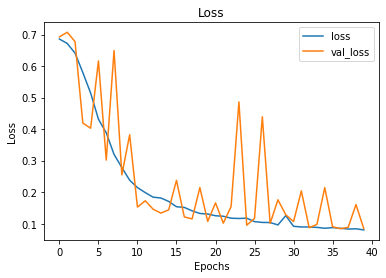

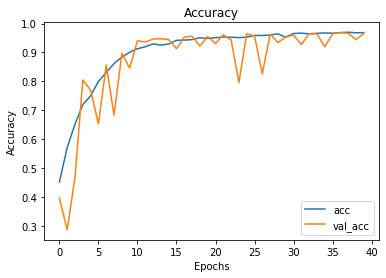

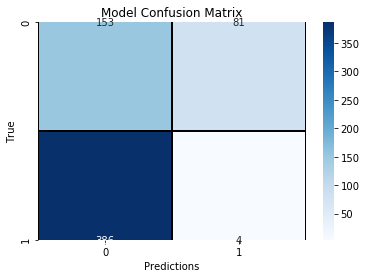

              precision    recall  f1-score   support

           0       0.28      0.65      0.40       234
           1       0.05      0.01      0.02       390

    accuracy                           0.25       624
   macro avg       0.17      0.33      0.21       624
weighted avg       0.14      0.25      0.16       624




20/20 [==============================] - 2s 73ms/step - loss: 0.9853 - acc: 0.7484
Test loss: 0.9853378534317017
Test acc: 0.7483974099159241


In [48]:
end = datetime.datetime.now()
elapsed = end - start
print('time {}'.format(elapsed))

model_results(results)




## model 4

In [49]:
#  adding more layers to see if that makes it better

In [50]:
model4 = Sequential()

model4.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 3)))
model4.add(Conv2D(32, (3, 3), activation = 'relu'))
model4.add(MaxPooling2D(2, 2))

model4.add(Conv2D(32, (3, 3), activation = 'relu'))
model4.add(Conv2D(32, (3, 3), activation = 'relu'))
model4.add(MaxPooling2D(2, 2))

model4.add(Conv2D(64, (3, 3), activation = 'relu'))
model4.add(Conv2D(64, (3, 3), activation = 'relu'))
model4.add(MaxPooling2D(2, 2))

model4.add(Conv2D(64, (3, 3), activation = 'relu'))
model4.add(Conv2D(64, (3, 3), activation = 'relu'))
model4.add(MaxPooling2D(2, 2))

model4.add(Conv2D(128, (3, 3), activation = 'relu'))
model4.add(MaxPooling2D(2, 2))

model4.add(Flatten())
model4.add(Dense(128, activation = 'relu'))
model4.add(Dense(64, activation = 'relu'))
model4.add(Dense(1, activation = 'sigmoid'))

model4.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['acc'])


In [51]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 58, 58, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 27, 27, 64)       

In [52]:
start = datetime.datetime.now()

results = model4.fit(train_images, 
                           train_labels,
                           epochs = 30, 
                           batch_size = 100,
                           validation_data = (val_images, val_labels),
                           class_weight = weight_dict, 
                           callbacks = callbacks)

Epoch 1/30
53/53 [==============================] - 114s 2s/step - loss: 0.6934 - acc: 0.7429 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/30
53/53 [==============================] - 115s 2s/step - loss: 0.6988 - acc: 0.7257 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 3/30
53/53 [==============================] - 116s 2s/step - loss: 0.6897 - acc: 0.7462 - val_loss: 0.6929 - val_acc: 0.5000
Epoch 4/30
53/53 [==============================] - 119s 2s/step - loss: 0.6947 - acc: 0.7403 - val_loss: 0.6928 - val_acc: 0.5000
Epoch 5/30
53/53 [==============================] - 122s 2s/step - loss: 0.6929 - acc: 0.7432 - val_loss: 0.6927 - val_acc: 0.5000
Epoch 6/30
53/53 [==============================] - 119s 2s/step - loss: 0.6947 - acc: 0.7429 - val_loss: 0.6926 - val_acc: 0.5625
Epoch 7/30
53/53 [==============================] - 120s 2s/step - loss: 0.6962 - acc: 0.7488 - val_loss: 0.6925 - val_acc: 0.5000
Epoch 8/30
53/53 [==============================] - 138s 3s/step - loss: 0.6833 - a

### model 4 results

time 15:57:45.365619


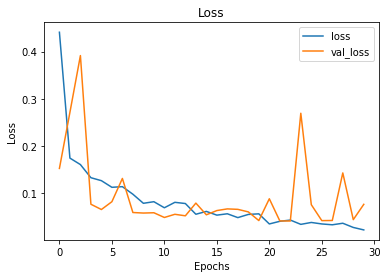

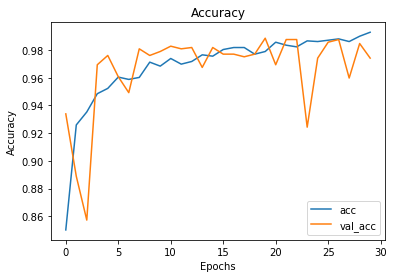

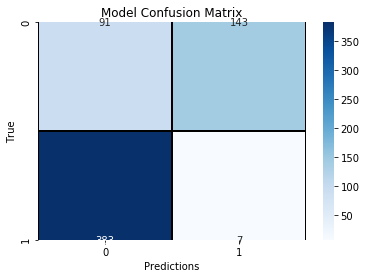

              precision    recall  f1-score   support

           0       0.19      0.39      0.26       234
           1       0.05      0.02      0.03       390

    accuracy                           0.16       624
   macro avg       0.12      0.20      0.14       624
weighted avg       0.10      0.16      0.11       624




20/20 [==============================] - 62s 3s/step - loss: 0.7813 - acc: 0.8429
Test loss: 0.7813320159912109
Test acc: 0.8429487347602844


In [88]:
end = datetime.datetime.now()
elapsed = end - start
print('time {}'.format(elapsed))

model_results(results)



## model 5

In [56]:
# try with less layers

In [54]:
model5 = Sequential()

model5.add(Conv2D(16, (3, 3), activation = 'relu', input_shape = (128, 128, 3)))
model5.add(MaxPooling2D(2, 2))

model5.add(Conv2D(16, (3, 3), activation = 'relu'))
model5.add(MaxPooling2D(2, 2))

model5.add(Conv2D(32, (3, 3), activation = 'relu'))
model5.add(MaxPooling2D(2, 2))

model5.add(Conv2D(32, (3, 3), activation = 'relu'))
model5.add(MaxPooling2D(2, 2))

model5.add(Flatten())
model5.add(Dense(64, activation = 'relu'))
model5.add(Dense(1, activation = 'sigmoid'))

model5.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['acc'])

In [55]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 12, 12, 32)       

In [56]:
start = datetime.datetime.now()

results = model5.fit(train_images,
                           train_labels,
                           epochs = 20,
                           batch_size = 32,
                           validation_data = (val_images, val_labels),
                           validation_split = .2,
                           class_weight = weight_dict,
                           callbacks = callbacks)

Epoch 1/20
131/131 [==============================] - 25s 185ms/step - loss: 0.6824 - acc: 0.4176 - val_loss: 0.6765 - val_acc: 0.8420
Epoch 2/20
131/131 [==============================] - 24s 183ms/step - loss: 0.6689 - acc: 0.6616 - val_loss: 0.7067 - val_acc: 0.3132
Epoch 3/20
131/131 [==============================] - 23s 174ms/step - loss: 0.6106 - acc: 0.7061 - val_loss: 0.3963 - val_acc: 0.9013
Epoch 4/20
131/131 [==============================] - 23s 174ms/step - loss: 0.4135 - acc: 0.8164 - val_loss: 0.2358 - val_acc: 0.9215
Epoch 5/20
131/131 [==============================] - 23s 175ms/step - loss: 0.2945 - acc: 0.8798 - val_loss: 0.2737 - val_acc: 0.8841
Epoch 6/20
131/131 [==============================] - 23s 173ms/step - loss: 0.2712 - acc: 0.8841 - val_loss: 0.1617 - val_acc: 0.9377
Epoch 7/20
131/131 [==============================] - 23s 174ms/step - loss: 0.1760 - acc: 0.9299 - val_loss: 0.2460 - val_acc: 0.9033
Epoch 8/20
131/131 [==============================] - 2

### model 5 results

time 0:10:52.516846


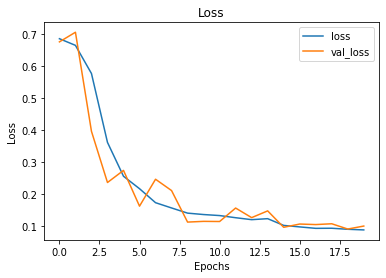

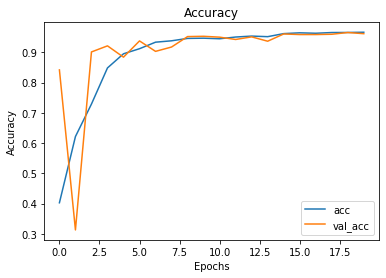

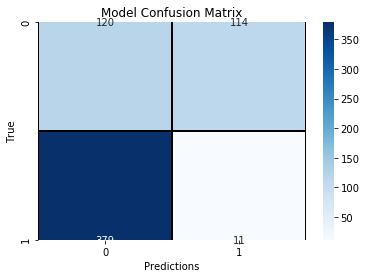

              precision    recall  f1-score   support

           0       0.24      0.51      0.33       234
           1       0.09      0.03      0.04       390

    accuracy                           0.21       624
   macro avg       0.16      0.27      0.19       624
weighted avg       0.15      0.21      0.15       624




20/20 [==============================] - 1s 40ms/step - loss: 0.7070 - acc: 0.7901
Test loss: 0.7069703340530396
Test acc: 0.7900640964508057


In [57]:
end = datetime.datetime.now()
elapsed = end - start
print('time {}'.format(elapsed))


model_results(results)



## model 6

In [58]:
#  using the same as model5 and adding RMSprop as optimizer 

model6 = Sequential()

model6.add(Conv2D(16, (3, 3), activation = 'relu', input_shape = (128, 128, 3)))
model6.add(MaxPooling2D(2, 2))

model6.add(Conv2D(16, (3, 3), activation = 'relu'))
model6.add(MaxPooling2D(2, 2))

model6.add(Conv2D(32, (3, 3), activation = 'relu'))
model6.add(MaxPooling2D(2, 2))

model6.add(Conv2D(32, (3, 3), activation = 'relu'))
model6.add(MaxPooling2D(2, 2))

model6.add(Flatten())
model6.add(Dense(64, activation = 'relu'))
model6.add(Dense(1, activation = 'sigmoid'))

model6.compile(loss = 'binary_crossentropy', optimizer = 'RMSprop', metrics = ['acc'])

In [59]:
model6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 61, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 12, 12, 32)       

In [60]:
start = datetime.datetime.now()

results = model6.fit(train_images, 
                           train_labels,
                           epochs = 20, 
                           batch_size = 32,
                           validation_data = (val_images, val_labels),
                           validation_split = .2,
                           callbacks = callbacks)

Epoch 1/20
131/131 [==============================] - 23s 169ms/step - loss: 0.5281 - acc: 0.7779 - val_loss: 0.1589 - val_acc: 0.9349
Epoch 2/20
131/131 [==============================] - 22s 170ms/step - loss: 0.1791 - acc: 0.9320 - val_loss: 0.1105 - val_acc: 0.9607
Epoch 3/20
131/131 [==============================] - 22s 170ms/step - loss: 0.1535 - acc: 0.9419 - val_loss: 0.1007 - val_acc: 0.9626
Epoch 4/20
131/131 [==============================] - 22s 170ms/step - loss: 0.1185 - acc: 0.9530 - val_loss: 0.0907 - val_acc: 0.9588
Epoch 5/20
131/131 [==============================] - 22s 170ms/step - loss: 0.1011 - acc: 0.9629 - val_loss: 0.1656 - val_acc: 0.9454
Epoch 6/20
131/131 [==============================] - 22s 170ms/step - loss: 0.0992 - acc: 0.9594 - val_loss: 0.0673 - val_acc: 0.9703
Epoch 7/20
131/131 [==============================] - 22s 171ms/step - loss: 0.0846 - acc: 0.9713 - val_loss: 0.2217 - val_acc: 0.9310
Epoch 8/20
131/131 [==============================] - 2

### model 6 results

time 0:07:42.388760


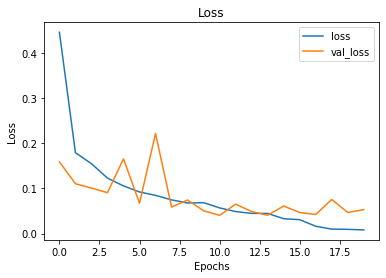

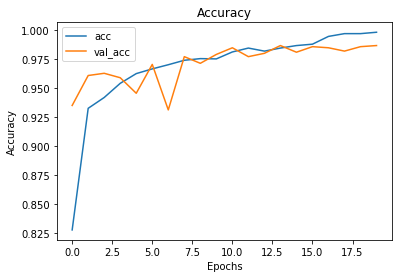

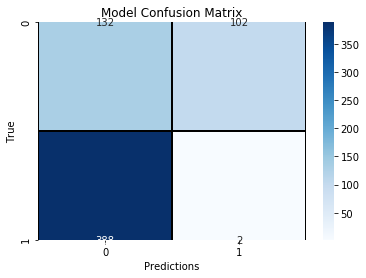

              precision    recall  f1-score   support

           0       0.25      0.56      0.35       234
           1       0.02      0.01      0.01       390

    accuracy                           0.21       624
   macro avg       0.14      0.28      0.18       624
weighted avg       0.11      0.21      0.14       624




20/20 [==============================] - 1s 41ms/step - loss: 1.8924 - acc: 0.7853
Test loss: 1.8924421072006226
Test acc: 0.7852563858032227


In [61]:

end = datetime.datetime.now()
elapsed = end - start
print('time {}'.format(elapsed))

model_results(results)



## model 7

In [62]:
# using model 4 with RMSprop 

model7 = Sequential()

model7.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 3)))
model7.add(Conv2D(32, (3, 3), activation = 'relu'))
model7.add(MaxPooling2D(2, 2))

model7.add(Conv2D(32, (3, 3), activation = 'relu'))
model7.add(Conv2D(32, (3, 3), activation = 'relu'))
model7.add(MaxPooling2D(2, 2))

model7.add(Conv2D(64, (3, 3), activation = 'relu'))
model7.add(Conv2D(64, (3, 3), activation = 'relu'))
model7.add(MaxPooling2D(2, 2))

model7.add(Conv2D(64, (3, 3), activation = 'relu'))
model7.add(Conv2D(64, (3, 3), activation = 'relu'))
model7.add(MaxPooling2D(2, 2))

model7.add(Conv2D(128, (3, 3), activation = 'relu'))
model7.add(MaxPooling2D(2, 2))

model7.add(Flatten())
model7.add(Dense(128, activation = 'relu'))
model7.add(Dense(64, activation = 'relu'))
model7.add(Dense(1, activation = 'sigmoid'))

model7.compile(loss = 'binary_crossentropy', optimizer = 'RMSprop', metrics = ['acc'])


In [63]:
model7.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 58, 58, 32)        9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 27, 27, 64)       

In [64]:
start = datetime.datetime.now()

results = model7.fit(train_images,
                           train_labels,
                           epochs = 30,
                           batch_size = 32,
                           validation_split = .2,
                           validation_data = (val_images, val_labels),
                           class_weight = weight_dict,
                           callbacks = callbacks)

Epoch 1/30
131/131 [==============================] - 99s 746ms/step - loss: 0.6896 - acc: 0.6527 - val_loss: 0.6879 - val_acc: 0.7395
Epoch 2/30
131/131 [==============================] - 99s 753ms/step - loss: 0.7929 - acc: 0.7405 - val_loss: 0.6504 - val_acc: 0.7701
Epoch 3/30
131/131 [==============================] - 98s 745ms/step - loss: 0.3882 - acc: 0.8400 - val_loss: 0.6444 - val_acc: 0.6475
Epoch 4/30
131/131 [==============================] - 98s 751ms/step - loss: 0.2459 - acc: 0.8856 - val_loss: 0.1505 - val_acc: 0.9464
Epoch 5/30
131/131 [==============================] - 99s 753ms/step - loss: 0.1819 - acc: 0.9274 - val_loss: 0.2445 - val_acc: 0.9186
Epoch 6/30
131/131 [==============================] - 98s 747ms/step - loss: 0.1484 - acc: 0.9420 - val_loss: 0.3432 - val_acc: 0.9061
Epoch 7/30
131/131 [==============================] - 98s 750ms/step - loss: 0.1733 - acc: 0.9444 - val_loss: 0.1019 - val_acc: 0.9665
Epoch 8/30
131/131 [==============================] - 9

### model 7 results

time 0:46:21.576350


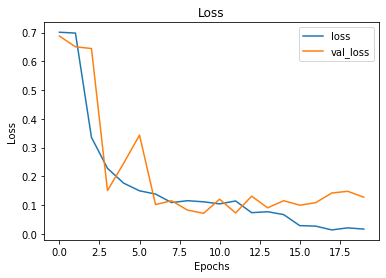

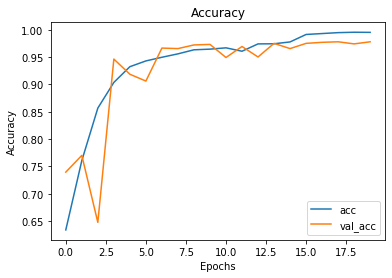

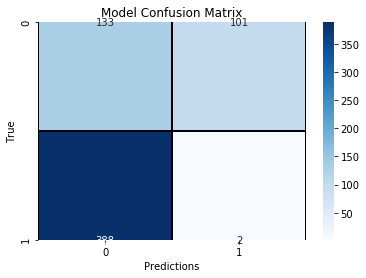

              precision    recall  f1-score   support

           0       0.26      0.57      0.35       234
           1       0.02      0.01      0.01       390

    accuracy                           0.22       624
   macro avg       0.14      0.29      0.18       624
weighted avg       0.11      0.22      0.14       624




20/20 [==============================] - 3s 155ms/step - loss: 3.7008 - acc: 0.7837
Test loss: 3.7008442878723145
Test acc: 0.7836538553237915


In [65]:
end = datetime.datetime.now()
elapsed = end - start
print('time {}'.format(elapsed))


model_results(results)



## model 8

In [87]:
# VGG19 with frozen layers

In [66]:
vgg_base = VGG19(weights = 'imagenet',
                include_top = False,
                input_shape = (128, 128, 3))

In [67]:
model8 = Sequential()

model8.add(vgg_base)
model8.add(Flatten())
model8.add(Dense(64, activation = 'relu'))
model8.add(Dense(1, activation = 'sigmoid'))

In [68]:
vgg_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [69]:
# check frozen layers

In [70]:
for layer in model8.layers:
    print(layer.name, layer.trainable)
    
print(len(model8.trainable_weights))

vgg19 True
flatten_7 True
dense_16 True
dense_17 True
36


In [71]:
# freezing the model

In [72]:
vgg_base.trainable = False

In [73]:
# checking that it froze

for layer in model8.layers:
    print(layer.name, layer.trainable)
    
print(len(model8.trainable_weights))

vgg19 False
flatten_7 True
dense_16 True
dense_17 True
4


In [74]:
model8.compile(loss = 'binary_crossentropy',
                           optimizer = 'RMSprop',
                           metrics = ['acc'])

In [75]:
model8.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                524352    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 20,548,801
Trainable params: 524,417
Non-trainable params: 20,024,384
_________________________________________________________________


In [76]:
start = datetime.datetime.now()

results = model8.fit(train_images, 
                           train_labels,
                           epochs = 30, 
                           batch_size = 100,
                           validation_data = (val_images, val_labels),
                           validation_split = .2,
                           callbacks = [early_stop])

Epoch 1/30
42/42 [==============================] - 432s 10s/step - loss: 0.7284 - acc: 0.7830 - val_loss: 0.1519 - val_acc: 0.9339
Epoch 2/30
42/42 [==============================] - 430s 10s/step - loss: 0.1793 - acc: 0.9249 - val_loss: 0.2709 - val_acc: 0.8889
Epoch 3/30
42/42 [==============================] - 429s 10s/step - loss: 0.1780 - acc: 0.9233 - val_loss: 0.3915 - val_acc: 0.8573
Epoch 4/30
42/42 [==============================] - 428s 10s/step - loss: 0.1667 - acc: 0.9334 - val_loss: 0.0758 - val_acc: 0.9693
Epoch 5/30
42/42 [==============================] - 428s 10s/step - loss: 0.1301 - acc: 0.9479 - val_loss: 0.0647 - val_acc: 0.9761
Epoch 6/30
42/42 [==============================] - 428s 10s/step - loss: 0.1257 - acc: 0.9573 - val_loss: 0.0812 - val_acc: 0.9607
Epoch 7/30
42/42 [==============================] - 429s 10s/step - loss: 0.1255 - acc: 0.9542 - val_loss: 0.1306 - val_acc: 0.9492
Epoch 8/30
42/42 [==============================] - 433s 10s/step - loss: 0.

### model 8 results

time 4:16:53.565767:


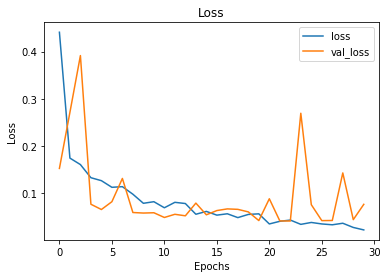

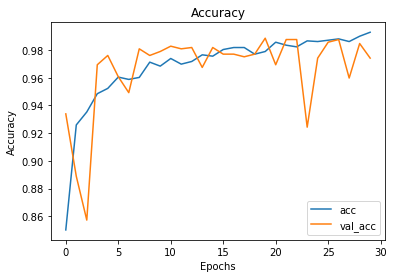

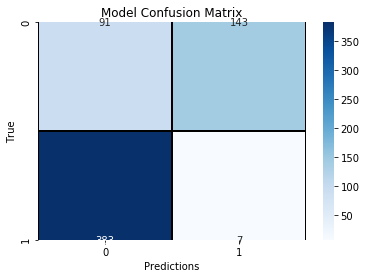

              precision    recall  f1-score   support

           0       0.19      0.39      0.26       234
           1       0.05      0.02      0.03       390

    accuracy                           0.16       624
   macro avg       0.12      0.20      0.14       624
weighted avg       0.10      0.16      0.11       624




20/20 [==============================] - 6821s 359s/step - loss: 0.7813 - acc: 0.8429
Test loss: 0.7813320159912109
Test acc: 0.8429487347602844


In [80]:
end = datetime.datetime.now()
elapsed = end - start
print('time {}:'.format(elapsed))

model_results(results)




In [124]:

print('train labels', train_labels[:50])

train labels [1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1.]


## using lime to explain the models

true class: 0.0
predicted class: 0


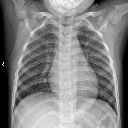

In [172]:
# random image and label
label = train_labels[5]
image = train_images[5]

# get model predict
pred = model8.predict(np.array([image]))
pred_class = int(pred.round())


print('true class:', label)
print('predicted class:', pred_class)
array_to_img(image)

In [179]:
explainer = lime_image.LimeImageExplainer()

In [182]:
# making an explainer

explanation = explainer.explain_instance(image.astype('double'), model8.predict, top_labels = 2, 
                                         hide_color = None, num_samples = 20)

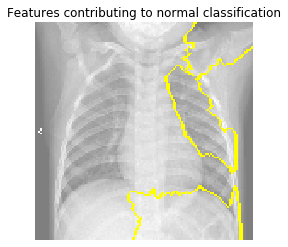

In [183]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                           positive_only = True, num_features = 10)
plt.imshow(mark_boundaries(temp / 2 + .5, mask))
plt.axis('off')
plt.title('Features contributing to normal classification')
plt.show()

true class: 1.0
predicted class: 0


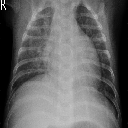

In [184]:
# trying out another image

label2 = train_labels[2]
image2 = train_images[2]

pred2 = model8.predict(np.array([image2]))
pred_class2 = int(pred.round())

print('true class:', label2)
print('predicted class:', pred_class2)
array_to_img(image2)

In [190]:
explanation2 = explainer.explain_instance(image2.astype('double'), model8.predict, top_labels = 2,
                                         hide_color = None, num_samples = 20)

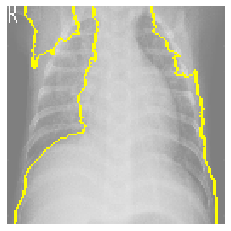

In [191]:
temp2, mask2 = explanation2.get_image_and_mask(explanation.top_labels[0],
                                             positive_only = True,
                                             num_features = 10)

plt.imshow(mark_boundaries(temp2 / 2 + .5, mask2))
plt.axis('off')
plt.show()

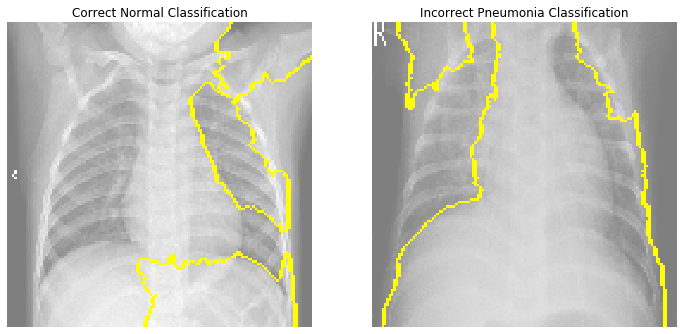

In [192]:
fig, axes = plt.subplots(1, 2, figsize = (12, 8))
axes[0].imshow(mark_boundaries(temp / 2 + .5, mask))
axes[1].imshow(mark_boundaries(temp2 / 2 + .5, mask2))
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title('Correct Normal Classification')
axes[1].set_title('Incorrect Pneumonia Classification')
plt.show()
#plt.savefig('normal_vs_incorrect.png')

In [169]:
# looking at the pros and cons 
# pros = green
# cons = red

Text(0.5, 1.0, 'correct classification')

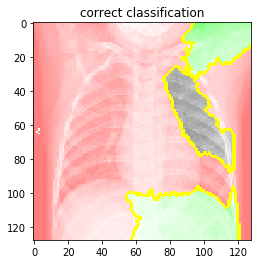

In [200]:
temp_pc, mask_pc = explanation.get_image_and_mask(explanation.top_labels[0], positive_only = False,
                                           num_features = 10, hide_rest = False)
plt.imshow(mark_boundaries( temp_pc / 2 + .5, mask_pc))
plt.title('correct classification')

Text(0.5, 1.0, 'incorrect classification')

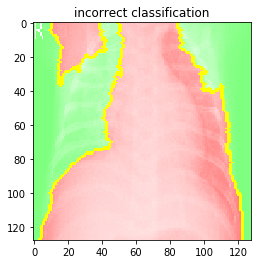

In [201]:
temp_pc2, mask_pc2 = explanation2.get_image_and_mask(explanation.top_labels[0], positive_only = False, 
                                           num_features = 10,  hide_rest = False)
plt.imshow(mark_boundaries( temp_pc2 / 2 + .5, mask_pc2))
plt.title('incorrect classification')